In [20]:
%pip install -q fastai


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [21]:
from pathlib import Path
import pandas as pd

from fastai.vision.all import *

# Paths – note the capital "Data" to match your folder
ROOT_DIR = Path.cwd().parent            # .../Fashion Recommender
DATA_DIR = ROOT_DIR / "Data"
MODELS_DIR = ROOT_DIR / "Models"

MODELS_DIR.mkdir(parents=True, exist_ok=True)

print("ROOT_DIR:", ROOT_DIR)
print("DATA_DIR:", DATA_DIR)
print("MODELS_DIR:", MODELS_DIR)


ROOT_DIR: /Users/ganenthraravindran/Desktop/Fashion Recommender
DATA_DIR: /Users/ganenthraravindran/Desktop/Fashion Recommender/Data
MODELS_DIR: /Users/ganenthraravindran/Desktop/Fashion Recommender/Models


In [22]:
# Path to list_bbox_inshop.txt
bbox_path = DATA_DIR / "list_bbox_inshop.txt"
print("bbox_path:", bbox_path)

# File structure:
#   line 1: <number_of_images>
#   line 2: "image_name clothes_type pose_type x_1 y_1 x_2 y_2"
#   line 3+: actual data rows
bbox_df = pd.read_csv(
    bbox_path,
    delim_whitespace=True,
    header=None,
    skiprows=2,  # skip count + header
)

print("Raw bbox_df shape:", bbox_df.shape)
display(bbox_df.head())


bbox_path: /Users/ganenthraravindran/Desktop/Fashion Recommender/Data/list_bbox_inshop.txt
Raw bbox_df shape: (52712, 7)


/var/folders/m_/ptg0zwqn0b34bnnmgnqwtkvm0000gn/T/ipykernel_71297/1481176265.py:9: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  bbox_df = pd.read_csv(


,0,1,2,3,4,5,6
0,img/WOMEN/Blouses_Shirts/id_00000001/02_1_front.jpg,1,1,50,49,208,235
1,img/WOMEN/Blouses_Shirts/id_00000001/02_2_side.jpg,1,2,119,48,136,234
2,img/WOMEN/Blouses_Shirts/id_00000001/02_3_back.jpg,1,3,50,42,213,240
3,img/WOMEN/Blouses_Shirts/id_00000001/02_4_full.jpg,1,4,82,30,162,129
4,img/WOMEN/Dresses/id_00000002/02_1_front.jpg,3,1,65,45,233,252


In [23]:
bbox_df.columns = ["image_path", "clothes_type", "pose_type", "x1", "y1", "x2", "y2"]

# Build products DataFrame from bbox info
products = bbox_df[["image_path"]].copy()

# Derive category from the folder structure.
# Example path: img/WOMEN/Blouses_Shirts/id_00000001/01_1_front.jpg
# Split by "/" -> ["img", "WOMEN", "Blouses_Shirts", "id_00000001", "01_1_front.jpg"]
# Take index 2 -> "Blouses_Shirts"
products["category_raw"] = products["image_path"].str.split("/").str[2]

# Optional: simplify category names (e.g. "Blouses_Shirts" -> "Blouse")
products["category"] = (
    products["category_raw"]
      .str.replace("Blouses_Shirts", "Blouse")
      .str.replace("Tees_Tanks", "Tee", regex=False)
      .str.replace("Dresses", "Dress", regex=False)
      .str.replace("Shorts", "Shorts", regex=False)
      .str.replace("Skirts", "Skirt", regex=False)
      .str.replace("Sweaters", "Sweater", regex=False)
      .str.replace("Cardigans", "Cardigan", regex=False)
      .str.replace("Jackets_Coats", "Jacket", regex=False)
)

# Add product_id and is_in_stock
products = products.reset_index(drop=True)
products["product_id"] = products.index + 1
products["is_in_stock"] = 1

print("products shape:", products.shape)
display(products.head())
print("\nTop categories:")
display(products["category"].value_counts().head(10))


products shape: (52712, 5)


,image_path,category_raw,category,product_id,is_in_stock
0,img/WOMEN/Blouses_Shirts/id_00000001/02_1_front.jpg,Blouses_Shirts,Blouse,1,1
1,img/WOMEN/Blouses_Shirts/id_00000001/02_2_side.jpg,Blouses_Shirts,Blouse,2,1
2,img/WOMEN/Blouses_Shirts/id_00000001/02_3_back.jpg,Blouses_Shirts,Blouse,3,1
3,img/WOMEN/Blouses_Shirts/id_00000001/02_4_full.jpg,Blouses_Shirts,Blouse,4,1
4,img/WOMEN/Dresses/id_00000002/02_1_front.jpg,Dresses,Dress,5,1



Top categories:


category
Tee                    14487
Blouse                  7964
Dress                   6999
Shorts                  4476
Sweater                 3641
Pants                   2821
Skirt                   2045
Jacket                  1895
Rompers_Jumpsuits       1696
Sweatshirts_Hoodies     1631
Name: count, dtype: int64

In [24]:
from pathlib import Path

sample_rel = products["image_path"].iloc[0]
print("Sample image_path:", sample_rel)

p = DATA_DIR / sample_rel
print("Full path:", p)
print("Exists:", p.exists())


Sample image_path: img/WOMEN/Blouses_Shirts/id_00000001/02_1_front.jpg
Full path: /Users/ganenthraravindran/Desktop/Fashion Recommender/Data/img/WOMEN/Blouses_Shirts/id_00000001/02_1_front.jpg
Exists: True


In [25]:
USE_SUBSET = False
N_SAMPLES = 20000

if USE_SUBSET:
    cats = products["category"].unique()
    per_cat = max(50, N_SAMPLES // len(cats))

    products_small = (
        products.groupby("category", group_keys=False)
                .apply(lambda x: x.sample(min(len(x), per_cat), random_state=42))
                .reset_index(drop=True)
    )
    print("Using subset:", products_small.shape)
else:
    products_small = products.copy()
    print("Using full dataset:", products_small.shape)

products_small.head()


Using full dataset: (52712, 5)


,image_path,category_raw,category,product_id,is_in_stock
0,img/WOMEN/Blouses_Shirts/id_00000001/02_1_front.jpg,Blouses_Shirts,Blouse,1,1
1,img/WOMEN/Blouses_Shirts/id_00000001/02_2_side.jpg,Blouses_Shirts,Blouse,2,1
2,img/WOMEN/Blouses_Shirts/id_00000001/02_3_back.jpg,Blouses_Shirts,Blouse,3,1
3,img/WOMEN/Blouses_Shirts/id_00000001/02_4_full.jpg,Blouses_Shirts,Blouse,4,1
4,img/WOMEN/Dresses/id_00000002/02_1_front.jpg,Dresses,Dress,5,1


Checking sample path: /Users/ganenthraravindran/Desktop/Fashion Recommender/Data/img/WOMEN/Blouses_Shirts/id_00000001/02_1_front.jpg
Sample exists: True


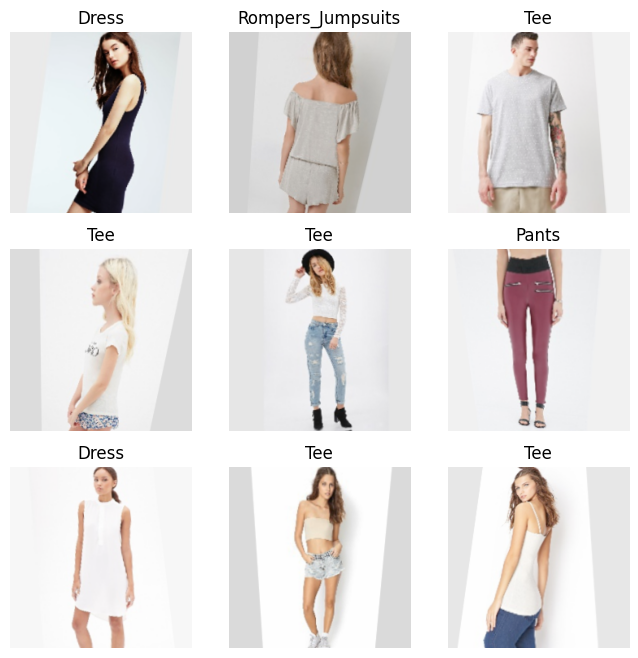

In [33]:
# DataBlock: how to build items and labels
# Create a getter function that properly constructs the path
def get_image_path(row):
    return DATA_DIR / row["image_path"]

dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_x=get_image_path,
    get_y=ColReader("category"),
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    item_tfms=Resize(224),
    batch_tfms=aug_transforms()
)

# Verify a sample path exists before creating dataloaders
sample_check = DATA_DIR / products_small.iloc[0]["image_path"]
print(f"Checking sample path: {sample_check}")
print(f"Sample exists: {sample_check.exists()}")

# Filter out any rows where the image doesn't exist
valid_products = products_small[
    products_small["image_path"].apply(lambda x: (DATA_DIR / x).exists())
]

# Create dataloaders
dls = dblock.dataloaders(
    valid_products,
    path=DATA_DIR,   # root where "img/..." lives
    bs=32           # drop to 16/8 if you run out of memory
)

dls.show_batch(max_n=9, nrows=3, figsize=(8, 8))

SuggestedLRs(valley=0.001737800776027143)

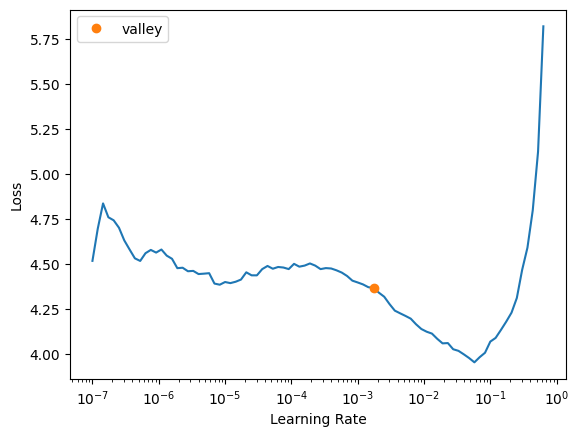

In [35]:
learn = vision_learner(dls, resnet18, metrics=accuracy)

learn.lr_find()


In [36]:
lr = 1e-3  # or use the suggestion from lr_find

learn.fine_tune(5, base_lr=lr)  # reduce 5 -> 3 if too slow

epoch,train_loss,valid_loss,accuracy,time
0,1.716425,1.356839,0.531873,09:46


epoch,train_loss,valid_loss,accuracy,time
0,1.176832,0.993219,0.650825,12:29
1,0.943435,0.809883,0.706982,12:31
2,0.829932,0.734951,0.732309,12:35
3,0.669490,0.674676,0.756118,12:29
4,0.622757,0.657413,0.760766,12:21


In [37]:
export_path = MODELS_DIR / "export.pkl"
learn.export(export_path)

print("Saved model to:", export_path)


Saved model to: /Users/ganenthraravindran/Desktop/Fashion Recommender/Models/export.pkl


Product ID: 17891
Category (table): Blouse
Image path: /Users/ganenthraravindran/Desktop/Fashion Recommender/Data/img/WOMEN/Blouses_Shirts/id_00002771/02_4_full.jpg


Predicted category: Tee


<Axes: >

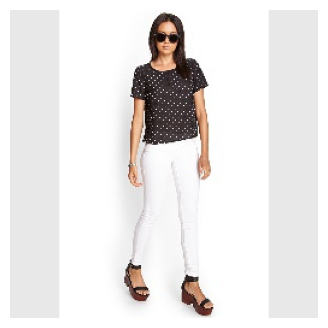

In [45]:
from random import randint

i = randint(0, len(products_small) - 1)
sample = products_small.iloc[i]

img_path = DATA_DIR / sample["image_path"]
print("Product ID:", sample["product_id"])
print("Category (table):", sample["category"])
print("Image path:", img_path)

img = PILImage.create(img_path)
pred_class, pred_idx, probs = learn.predict(img)
print("Predicted category:", pred_class)

img.show(figsize=(4, 4))
